In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix

In [2]:
df = pd.concat([pd.read_excel('tracks_features_plus_popularity_1922_1979.xlsx', usecols="B:AA"),
                         pd.read_excel('tracks_features_plus_popularity_final.xlsx', usecols="C:AB")])
df = df[df['year'] >= 1923]
df.head()

/home/andrepalhares/.local/lib/python3.8/site-packages/pandas/io/excel/_base.py:1272: FutureWarning: Defining usecols with out of bounds indices is deprecated and will raise a ParserError in a future version.
  return self._reader.parse(


,id,name,album,album_id,artists,artist_ids,track_number,disc_number,explicit,danceability,...,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,release_date,popularity
0,4MdlxZHzUi8fGvuXOtNVhb,Johnny B. Goode - Live,Johnny Winter: A Rock N' Roll Collection,6yn5Mylr8HsH9PVro7Fo22,['Johnny Winter'],['2ODUxmFxJSyvGiimNhMHbO'],1,1,False,0.415,...,0.023,0.077100,0.9410,0.924,159.366,203407,4,1973,1973,6
1,576DmaRTiVhm3l00mpQwDm,Good Morning Little School Girl - Live,Johnny Winter: A Rock N' Roll Collection,6yn5Mylr8HsH9PVro7Fo22,['Johnny Winter'],['2ODUxmFxJSyvGiimNhMHbO'],2,1,False,0.294,...,0.188,0.422000,0.9740,0.639,187.886,276968,4,1973,1973,4
2,3k3Q8IZ5oOqCUfOP2UPgpW,I'll Drown in My Tears,Johnny Winter: A Rock N' Roll Collection,6yn5Mylr8HsH9PVro7Fo22,['Johnny Winter'],['2ODUxmFxJSyvGiimNhMHbO'],3,1,False,0.424,...,0.827,0.000021,0.0742,0.390,95.799,285360,3,1973,1973,2
3,1fuxmrrP5JKu0eeHi1c7Ug,When You Got A Good Friend,Johnny Winter: A Rock N' Roll Collection,6yn5Mylr8HsH9PVro7Fo22,['Johnny Winter'],['2ODUxmFxJSyvGiimNhMHbO'],4,1,False,0.504,...,0.831,0.030000,0.1680,0.787,146.244,218453,4,1973,1973,3
4,6yziyzrBhA2mFApoJKAill,Be Careful with a Fool,Johnny Winter: A Rock N' Roll Collection,6yn5Mylr8HsH9PVro7Fo22,['Johnny Winter'],['2ODUxmFxJSyvGiimNhMHbO'],5,1,False,0.293,...,0.494,0.022300,0.2080,0.730,206.991,315133,3,1973,1973,4


In [3]:
def obter_decada(linha):
    ano = str(linha['year'])
    return int(ano[:3] + "0")

df['decade'] = df.apply (lambda x: obter_decada(x), axis=1)

In [4]:
df = df[df['decade'] != "00"]
df.groupby('decade').size()

decade
1920      427
1930      446
1940      638
1950     3099
1960     8596
1970    16849
1980     4379
1990    29907
2000    99990
2010    22524
dtype: int64

## 

In [5]:
df_1980 = df[df['decade'] == 1980].sort_values(by=['popularity'], ascending=False)[:1500]
df_1990 = df[df['decade'] == 1990].sort_values(by=['popularity'], ascending=False)[:1500]
df_2000 = df[df['decade'] == 2000].sort_values(by=['popularity'], ascending=False)[:1500]
df_2010 = df[df['decade'] == 2010].sort_values(by=['popularity'], ascending=False)[:1500]

df_1980_a_2010 = pd.concat([df_1980, df_1990, df_2000, df_2010], ignore_index=True, sort=False)

df_1980_a_2010.groupby('decade').size()

decade
1980    1500
1990    1500
2000    1500
2010    1500
dtype: int64

## Dividindo o dataset em bases de teste e treino 

In [6]:
atributos = ['danceability', 'energy', 'key', 'loudness', 'mode', 
        'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
        'valence', 'tempo', 'duration_ms', 'time_signature']

X = df_1980_a_2010[atributos]
y = pd.factorize(df_1980_a_2010['decade'])[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [7]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.fit_transform(X_test)

## Encontrando os melhores parâmetros

In [8]:
from sklearn.model_selection import RandomizedSearchCV

random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 1000, stop = 5000, num = 15)], # quantidade de árvores
               'max_depth': [int(x) for x in np.linspace(10, 210, num = 11)], # número máximo de níveis
              } 

In [9]:
rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions=random_grid, 
                               n_iter = 100, 
                               cv=3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs=-1
                              )

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 30, 50, 70, 90, 110,
                                                      130, 150, 170, 190, 210],
                                        'n_estimators': [1000, 1285, 1571, 1857,
                                                         2142, 2428, 2714, 3000,
                                                         3285, 3571, 3857, 4142,
                                                         4428, 4714, 5000]},
                   random_state=42, verbose=2)

### 

In [10]:
rfc = RandomForestClassifier(n_estimators=rf_random.best_params_['n_estimators'], max_depth=rf_random.best_params_['max_depth'])

rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=50, n_estimators=2714)

In [11]:
y_pred = rfc.predict(X_test)

print("accuracy_score:",metrics.accuracy_score(y_test, y_pred))
print("f1_score:",metrics.f1_score(y_test, y_pred, average='weighted'))

accuracy_score: 0.5344444444444445
f1_score: 0.5298788505156868


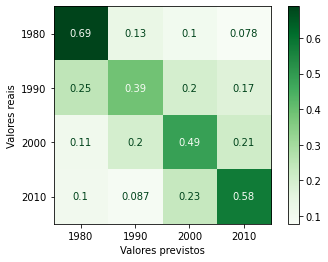

In [12]:
disp = plot_confusion_matrix(rfc, X_test, y_test,
                             display_labels=[1980, 1990, 2000, 2010],
                             cmap=plt.cm.Greens,
                             normalize='true')
plt.xlabel('Valores previstos')
plt.ylabel('Valores reais')
plt.show()

In [13]:
atributos_importancia = pd.Series(rfc.feature_importances_,index=atributos).sort_values(ascending=False)
atributos_importancia

loudness            0.149985
valence             0.095373
duration_ms         0.093338
acousticness        0.091338
energy              0.090932
speechiness         0.090858
danceability        0.084149
liveness            0.080883
tempo               0.079677
instrumentalness    0.071902
key                 0.048911
mode                0.013293
time_signature      0.009360
dtype: float64

<AxesSubplot:>

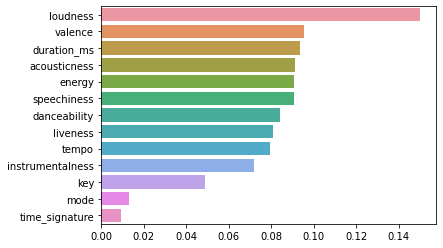

In [14]:
sns.barplot(x=atributos_importancia, y=atributos_importancia.index)

In [15]:
df_1920 = df[df['decade'] == 1920].sort_values(by=['popularity'], ascending=False)[:129]
df_1930 = df[df['decade'] == 1930].sort_values(by=['popularity'], ascending=False)[:129]
df_1940 = df[df['decade'] == 1940].sort_values(by=['popularity'], ascending=False)[:129]
df_1950 = df[df['decade'] == 1950].sort_values(by=['popularity'], ascending=False)[:129]
df_1960 = df[df['decade'] == 1960].sort_values(by=['popularity'], ascending=False)[:129]
df_1970 = df[df['decade'] == 1970].sort_values(by=['popularity'], ascending=False)[:129]

df_1922_a_1980 = pd.concat([df_1920, df_1930, df_1940, df_1950, df_1960, df_1970], ignore_index=True, sort=False)

X = df_1922_a_1980[atributos]
y = pd.factorize(df_1922_a_1980['decade'])[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [16]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.fit_transform(X_test)

In [17]:
from sklearn.model_selection import RandomizedSearchCV

random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 1000, stop = 5000, num = 15)], # quantidade de árvores
               'max_depth': [int(x) for x in np.linspace(10, 210, num = 11)], # número máximo de níveis
              } 

In [18]:
rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions=random_grid, 
                               n_iter = 100, 
                               cv=3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs=-1
                              )

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ...................max_depth=190, n_estimators=1000; total time=  42.9s
[CV] END ...................max_depth=150, n_estimators=3857; total time=  52.2s
[CV] END ...................max_depth=170, n_estimators=4142; total time=  45.5s
[CV] END ...................max_depth=130, n_estimators=2428; total time=  24.9s
[CV] END ....................max_depth=30, n_estimators=5000; total time=  60.0s
[CV] END ...................max_depth=210, n_estimators=3285; total time=  35.7s
[CV] END ....................max_depth=70, n_estimators=2714; total time=  23.7s
[CV] END ...................max_depth=190, n_estimators=3857; total time=  41.9s
[CV] END ....................max_depth=30, n_estimators=2142; total time=  21.4s
[CV] END ...................max_depth=110, n_estimators=3857; total time=  44.2s
[CV] END ....................max_depth=30, n_estimators=3571; total time=  34.6s
[CV] END ....................max_depth=50, n_e

[CV] END ...................max_depth=150, n_estimators=3857; total time= 1.5min
[CV] END ...................max_depth=170, n_estimators=4142; total time=  39.2s
[CV] END ....................max_depth=70, n_estimators=3857; total time=  39.0s
[CV] END ....................max_depth=30, n_estimators=5000; total time= 1.0min
[CV] END ....................max_depth=70, n_estimators=2714; total time=  27.2s
[CV] END ...................max_depth=130, n_estimators=4142; total time=  38.6s
[CV] END ....................max_depth=30, n_estimators=2142; total time=  20.7s
[CV] END ....................max_depth=30, n_estimators=2142; total time=  21.7s
[CV] END ....................max_depth=30, n_estimators=1000; total time=   9.8s
[CV] END ....................max_depth=30, n_estimators=1000; total time=  11.4s
[CV] END ....................max_depth=30, n_estimators=1000; total time=  13.3s
[CV] END ....................max_depth=90, n_estimators=2714; total time=  26.9s
[CV] END ...................

[CV] END ....................max_depth=30, n_estimators=3571; total time=  33.9s
[CV] END ...................max_depth=150, n_estimators=1000; total time=   9.0s
[CV] END ...................max_depth=150, n_estimators=1000; total time=   9.0s
[CV] END ...................max_depth=150, n_estimators=1000; total time=   9.7s
[CV] END ...................max_depth=210, n_estimators=1857; total time=  13.7s
[CV] END ...................max_depth=210, n_estimators=1857; total time=  14.3s
[CV] END ...................max_depth=110, n_estimators=1000; total time=   8.6s
[CV] END ....................max_depth=30, n_estimators=1857; total time=  16.5s
[CV] END ....................max_depth=10, n_estimators=4428; total time=  30.9s
[CV] END ....................max_depth=50, n_estimators=1285; total time=  10.9s
[CV] END ....................max_depth=50, n_estimators=1285; total time=  11.0s
[CV] END ...................max_depth=130, n_estimators=3285; total time=  28.2s
[CV] END ...................

[CV] END ....................max_depth=30, n_estimators=1285; total time=  11.1s
[CV] END ....................max_depth=30, n_estimators=1857; total time=  16.3s
[CV] END ....................max_depth=10, n_estimators=3571; total time=  24.9s
[CV] END ....................max_depth=10, n_estimators=3571; total time=  24.9s
[CV] END ...................max_depth=210, n_estimators=2714; total time=  23.0s
[CV] END ....................max_depth=70, n_estimators=4142; total time=  35.7s
[CV] END ...................max_depth=170, n_estimators=5000; total time=  42.9s
[CV] END ...................max_depth=210, n_estimators=4142; total time=  36.5s
[CV] END ...................max_depth=110, n_estimators=1857; total time=  15.7s
[CV] END ...................max_depth=110, n_estimators=3571; total time=  30.4s
[CV] END ...................max_depth=130, n_estimators=2142; total time=  17.9s
[CV] END ....................max_depth=50, n_estimators=4428; total time=  38.1s
[CV] END ...................

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 30, 50, 70, 90, 110,
                                                      130, 150, 170, 190, 210],
                                        'n_estimators': [1000, 1285, 1571, 1857,
                                                         2142, 2428, 2714, 3000,
                                                         3285, 3571, 3857, 4142,
                                                         4428, 4714, 5000]},
                   random_state=42, verbose=2)

In [19]:
rfc = RandomForestClassifier(n_estimators=rf_random.best_params_['n_estimators'], max_depth=rf_random.best_params_['max_depth'])

rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=190, n_estimators=1000)

In [20]:
y_pred = rfc.predict(X_test)

print("accuracy_score:",metrics.accuracy_score(y_test, y_pred))
print("f1_score:",metrics.f1_score(y_test, y_pred, average='weighted'))

accuracy_score: 0.592274678111588
f1_score: 0.5892680750697095


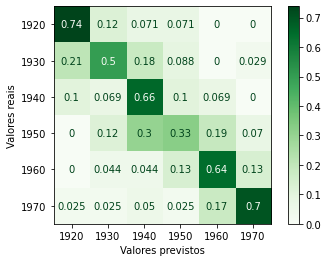

In [21]:
disp = plot_confusion_matrix(rfc, X_test, y_test,
                             display_labels=[1920, 1930, 1940, 1950, 1960, 1970],
                             cmap=plt.cm.Greens,
                             normalize='true')
plt.xlabel('Valores previstos')
plt.ylabel('Valores reais')
plt.show()

In [22]:
atributos_importancia = pd.Series(rfc.feature_importances_,index=atributos).sort_values(ascending=False)
atributos_importancia

acousticness        0.167102
duration_ms         0.112221
instrumentalness    0.097705
energy              0.096667
danceability        0.089773
speechiness         0.086769
valence             0.085949
loudness            0.079285
liveness            0.062402
tempo               0.059422
key                 0.041637
time_signature      0.011437
mode                0.009631
dtype: float64

<AxesSubplot:>

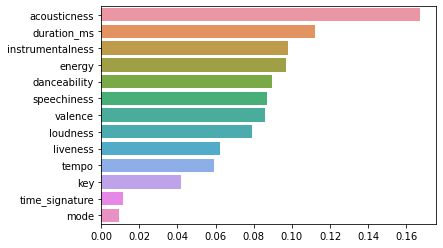

[CV] END ....................max_depth=90, n_estimators=3571; total time=   9.2s
[CV] END ....................max_depth=30, n_estimators=4142; total time=   9.9s
[CV] END ...................max_depth=150, n_estimators=4428; total time=  11.2s
[CV] END ...................max_depth=130, n_estimators=1857; total time=   4.3s
[CV] END ...................max_depth=170, n_estimators=4714; total time=  10.8s
[CV] END ...................max_depth=110, n_estimators=3000; total time=   6.8s
[CV] END ....................max_depth=30, n_estimators=3000; total time=   6.8s
[CV] END ....................max_depth=90, n_estimators=3000; total time=   6.9s
[CV] END ...................max_depth=130, n_estimators=3000; total time=   6.9s
[CV] END ....................max_depth=10, n_estimators=4142; total time=   9.4s
[CV] END ...................max_depth=110, n_estimators=4142; total time=   9.5s
[CV] END ....................max_depth=30, n_estimators=4428; total time=  10.2s
[CV] END ...................

[CV] END ...................max_depth=130, n_estimators=2142; total time=   4.9s
[CV] END ....................max_depth=70, n_estimators=1000; total time=   2.5s
[CV] END ....................max_depth=50, n_estimators=4428; total time=  10.8s
[CV] END ...................max_depth=210, n_estimators=2142; total time=   5.8s
[CV] END ....................max_depth=30, n_estimators=4142; total time=   9.9s
[CV] END ...................max_depth=190, n_estimators=2714; total time=   6.9s
[CV] END ...................max_depth=150, n_estimators=4428; total time=  10.6s
[CV] END ....................max_depth=50, n_estimators=2714; total time=   6.2s
[CV] END ....................max_depth=50, n_estimators=2714; total time=   6.2s
[CV] END ...................max_depth=110, n_estimators=3000; total time=   6.9s
[CV] END ...................max_depth=170, n_estimators=2714; total time=   6.2s
[CV] END ....................max_depth=90, n_estimators=3000; total time=   6.9s
[CV] END ...................

In [23]:
sns.barplot(x=atributos_importancia, y=atributos_importancia.index)